<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{beans-XXX} -->

Use Weights & Biases for machine learning experiment tracking, dataset versioning, and project collaboration.


<img src="https://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />


## What this notebook covers with Weights and Biases:
* Metrics logging 
* Exploratory Data Analysis (EDA)
* W&B plots such as Confusion Matrices, ROC curves & PR curves
* HyperParameter search with W&B Sweeps



# ✅ Sign Up

Sign up to a free [Weights & Biases account here](https://wandb.ai/signup)

# Kaggle Competition Page

[Submit to the Competition here](https://www.kaggle.com/t/87d1cc8a1e1d423caa627baecba62365)

# 🚀 Installing and importing

In [ ]:
!pip install -q --upgrade wandb
!pip install -q scikit-learn==1.0.1

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
     |████████████████████████████████| 144 kB 45.1 MB/s 
     |████████████████████████████████| 181 kB 35.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 23.2 MB 2.4 MB/s 


In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 61 kB/s 


In [ ]:
import os
import wandb
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

A useful logging function to log multiple metrics to W&B at once

In [ ]:
def log_metrics(labels, preds, is_val=True):
  if is_val: pref = 'validation'
  else: pref = 'train'
  
  metrics = {}
  metrics[f"{pref}/accuracy_score"] = accuracy_score(y_val, y_pred)
  metrics[f"{pref}/precision"] = precision_score(y_val, y_pred, average="weighted")
  metrics[f"{pref}/recall"] = recall_score(y_val, y_pred, average="weighted")
  metrics[f"{pref}/f1_score"] = f1_score(y_val, y_pred, average="weighted")

  for k in metrics.keys():
    print(f'{k} : {metrics[k]}')
    wandb.summary[f"{k}"] = metrics[k]

  #wandb.log(metrics)

Set some constants 

In [ ]:
PROJECT = 'beans-tabular-IIT-G'
DATA_DIR = '/content/drive/MyDrive/W&B'
ARTIFACT_PATH = 'wandb_fc/beans-tabular-pydata-tunisia/beans_competition_dataset:latest'

# 💾 Data
#### Download and Load the Data
`train.csv` and `val.csv` data will be downloaded to `DATA_DIR`


In [ ]:
wandb.init(project=PROJECT, job_type='download_dataset')
artifact = wandb.use_artifact(ARTIFACT_PATH, type='dataset')
artifact_dir = artifact.download(DATA_DIR)
wandb.finish()

wandb: Currently logged in as: atufa (use `wandb login --relogin` to force relogin)


In [ ]:
# Read csvs to DataFrame
train_df = pd.read_csv(f'{DATA_DIR}/train_c.csv')
train_df = train_df.sample(frac=1)  # shuffle the train data
train_df.reset_index(inplace=True, drop=True)

val_df = pd.read_csv(f'{DATA_DIR}/val.csv')
test_df = pd.read_csv(f'{DATA_DIR}/test_no_label.csv')

train_df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class,id
0,44738,810.865,324.986219,175.677420,1.849903,0.841300,45116,238.667532,0.800981,0.991622,0.855046,0.734393,0.007264,0.001303,0.539333,0.997713,HOROZ,5537
1,-41818,780.604,307.299549,174.250451,1.763551,0.823692,42245,230.747332,0.788528,0.989892,0.862406,0.750887,0.007348,0.001441,0.563832,0.994346,SIRA,5428
2,37884,703.214,246.514878,195.983905,1.257832,0.606585,38173,219.625606,0.799494,0.992429,0.962699,0.890922,0.006507,0.002529,0.793743,0.998395,SEKER,4133
3,-47174,808.254,300.465722,200.607132,1.497782,0.744472,47646,245.079176,0.751753,0.990094,0.907438,0.815664,0.006369,0.001739,0.665308,0.996487,SIRA,486
4,-42946,751.381,258.600293,211.657134,1.221789,0.574546,43341,233.838717,0.761535,0.990886,0.955899,0.904248,0.006022,0.002483,0.817664,0.999012,SEKER,6565


In [ ]:
test_df

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,id
0,68008,996.629,371.705881,234.441758,1.585493,0.776012,69070,294.262595,0.725465,0.984624,0.860405,0.791654,0.005466,0.001324,0.626717,0.993655,0
1,33169,676.789,242.434085,174.652218,1.388096,0.693547,33629,205.504458,0.766701,0.986321,0.909988,0.847671,0.007309,0.002328,0.718547,0.997412,1
2,32279,670.977,250.820564,164.181397,1.527704,0.755995,32662,202.728635,0.757190,0.988274,0.900979,0.808262,0.007770,0.002046,0.653287,0.998029,2
3,47480,809.477,308.172912,197.172445,1.562961,0.768532,47977,245.872759,0.811915,0.989641,0.910566,0.797840,0.006491,0.001622,0.636549,0.994902,3
4,35615,692.536,233.003591,195.224650,1.193515,0.545883,36004,212.947004,0.743342,0.989196,0.933164,0.913922,0.006542,0.002815,0.835253,0.996887,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3398,38491,745.466,278.802822,176.662392,1.578167,0.773623,39247,221.378100,0.726341,0.980737,0.870389,0.794031,0.007243,0.001776,0.630485,0.995011,3398
3399,43489,769.887,285.884484,194.201811,1.472100,0.733859,43893,235.312377,0.807415,0.990796,0.922009,0.823103,0.006574,0.001861,0.677499,0.997346,3399
3400,50400,857.430,327.844472,198.024117,1.655579,0.796970,51001,253.320495,0.686695,0.988216,0.861476,0.772685,0.006505,0.001430,0.597042,0.988450,3400
3401,43378,787.214,304.180475,182.437741,1.667311,0.800174,43943,235.011883,0.774801,0.987142,0.879617,0.772607,0.007012,0.001541,0.596921,0.995253,3401


#### Prep Data
Extract the X,y values and encode the classes into integer values

In [ ]:
le = preprocessing.LabelEncoder()

y_train_txt = train_df['Class'].values.tolist()
le.fit(y_train_txt)
labels = le.classes_

X_train = train_df.iloc[:,:-2].values.tolist()
y_train = le.transform(y_train_txt)

X_val = val_df.iloc[:,:-2].values.tolist()
y_val_txt = val_df['Class'].values.tolist()
y_val = le.transform(y_val_txt)

X_test = test_df.iloc[:,:-1].values.tolist()

labels = train_df['Class'].unique()

list(le.inverse_transform([2, 2, 1]))

['CALI', 'CALI', 'BOMBAY']

# 🖼️ EDA with W&B Tables
Log the train and validation datasets to W&B Tables for EDA

In [ ]:
wandb.init(project=PROJECT, job_type='log_dataset')
wandb.log({'Datasets/train_ds':train_df})
wandb.log({'Datasets/val_ds':val_df})
wandb.finish()

#👟 Train
Train a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) from sci-kit learn

In [ ]:
wandb.init(project=PROJECT)

model = RandomForestClassifier()

# ✍️ Log your Models parameter config to W&B
wandb.config.update(model.get_params())

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_val)
y_probas = model.predict_proba(X_val)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

✍️ Log your model's Metrics to W&B

In [ ]:
log_metrics(y_val, y_pred)

validation/accuracy_score : 0.9298642533936652
validation/precision : 0.9297594811862108
validation/recall : 0.9298642533936652
validation/f1_score : 0.9297881117888325


#🤩 Visualize Model Performance in W&B
Weights & Biases have charting functions for popular model evaluation charts including confusion matrices, ROC curves, PR curves and more.
[Check out wandb charts documentation here $\rightarrow$](https://docs.wandb.ai/guides/track/log/plots#model-evaluation-charts)

**Confusion Matrix**


In [ ]:
wandb.log({"confusion Matrix" : wandb.plot.confusion_matrix(y_probas, y_val, class_names=labels)})

**ROC Curve**


In [ ]:
wandb.log({"ROC Curve": wandb.plot.roc_curve(y_val, y_probas, labels=labels, title='ROC Curve')})

**Precision Recall Curve**

In [ ]:
wandb.log({"Precision-Recall": wandb.plot.pr_curve(y_val, y_probas, labels=labels, title='Precision-Recall')})

**Feature Importances**

Evaluates and plots the importance of each feature for the classification task. Only works with classifiers that have a `feature_importances_` attribute, like trees.

In [ ]:
feat_names = train_df.columns.values
imps = []
feats = []
for i in indices:
  imps.append(importances[i])
  feats.append(feat_names[i])

fi_data = pd.DataFrame({"Feature":feats, "Importance":imps})

In [ ]:
table = wandb.Table(data=fi_data, columns = ["Feature", "Importance"])
wandb.log({"Feature Importance" : wandb.plot.bar(table, "Feature",
                               "Importance", title="Feature Importance")})

#### 🏁 Finish W&B Run
When you're finished with your logging for a run make sure to call `wandb.finish()` to avoid logging metrics from your next experiment to the wrong run

In [ ]:
wandb.finish()

validation/accuracy_score,0.92986
validation/f1_score,0.92979
validation/precision,0.92976
validation/recall,0.92986


# Submission

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test = list(le.inverse_transform(y_pred_test))
ids = test_df.id.values

submission_df = pd.DataFrame({'Id':ids, 'Predicted':y_pred_test})
submission_df.to_csv('submission.csv', index=False)

# 🧪 HyperParameter Sweep

Weights and Biases also enables you to do hyperparameter sweeps, either with our own [Sweeps functionality](https://docs.wandb.ai/guides/sweeps/python-api).

#### Sweep Train Function
A W&B Sweep needs to passed in a config and a training function to run.

* RandomForest

In [ ]:
def train():     
    with wandb.init() as _:
      model = RandomForestClassifier(
          
          n_estimators=wandb.config['n_estimators'],   # n_estimators parameter will now be set by W&B
          max_depth=wandb.config['max_depth']     # max_depth parameter will now be set by W&B
          
          # [Optional] add additional model parameters here
          
          )
    
      
      # ✍️ Log your Models parameter config to W&B
      wandb.config['model_type'] = 'random_forest'
      wandb.config.update(model.get_params())

      model.fit(X_train, y_train)

      y_pred_train = model.predict(X_train)
      y_pred = model.predict(X_val)
      y_probas = model.predict_proba(X_val)
        
      # Log validation summary metrics to W&B
      wandb.summary["validation/accuracy"] = accuracy_score(y_val, y_pred)
      wandb.summary["validation/precision"] = precision_score(y_val, y_pred, average="weighted")
      wandb.summary["validation/recall"] = recall_score(y_val, y_pred, average="weighted")
      wandb.summary["validation/f1_score"] = f1_score(y_val, y_pred, average="weighted")
    
      # Make test set predictions and save as csv  
      y_pred_test = model.predict(X_test)
      y_pred_test = list(le.inverse_transform(y_pred_test))

      submission_df = pd.DataFrame({'Id':test_df.id.values, 'Predicted':y_pred_test})
      submission_df.to_csv('submission.csv', index=False)
        
      wandb.log_artifact('submission.csv', name=f'{wandb.run.id}_submission', type='submission')

* Catboost Classifier

In [ ]:
from catboost import CatBoostClassifier
def train_cat():     
    with wandb.init() as _:
      model = CatBoostClassifier(verbose=False,bootstrap_type='Bernoulli',iterations=200,
                                   colsample_bylevel=wandb.config["colsample_bylevel"],
                                   depth=wandb.config["depth"],
                                   boosting_type="Ordered",
                                   subsample=wandb.config["subsample"],
                                   random_state=0)

      
      # ✍️ Log your Models parameter config to W&B
      wandb.config['model_type'] = 'catboost_model'
      wandb.config.update(model.get_params())

      model.fit(X_train, y_train)

      y_pred_train = model.predict(X_train)
      y_pred = model.predict(X_val)
      y_probas = model.predict_proba(X_val)
        
      # Log validation summary metrics to W&B
      wandb.summary["validation/accuracy"] = accuracy_score(y_val, y_pred)
      wandb.summary["validation/precision"] = precision_score(y_val, y_pred, average="weighted")
      wandb.summary["validation/recall"] = recall_score(y_val, y_pred, average="weighted")
      wandb.summary["validation/f1_score"] = f1_score(y_val, y_pred, average="weighted")
    
      # Make test set predictions and save as csv  
      y_pred_test = model.predict(X_test)
      y_pred_test = list(le.inverse_transform(y_pred_test))

      submission_df = pd.DataFrame({'Id':test_df.id.values, 'Predicted':y_pred_test})
      submission_df.to_csv('submission.csv', index=False)
        
      wandb.log_artifact('submission.csv', name=f'{wandb.run.id}_submission', type='submission')

💡 **Tip**

The `train` function above uses Sci-Kit Learn's [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) but you can also modify the code to user other models such as `DecisionTreeClassifier` or `AdaBoostClassifier` or other boosting models such as [`XGBoost`](https://xgboost.readthedocs.io/en/latest/get_started.html). 

Note that you'll likely have to chanage the argument names in the `sweep_config` when using these models in a sweep.


```
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

model = DecisionTreeClassifier()
model = AdaBoostClassifier()
```



#### Sweep Config
Define the name of your sweep, how you'd like to sweep and what parameters to sweep over. See the [Sweep Configuration Docs](https://docs.wandb.ai/guides/sweeps/configuration) here for more advanced functionality

* Catboost

In [ ]:
sweep_config_cat = {
  "name" : "beans_sweep_cat",
  "method" : "random",
  "parameters" : {
    "colsample_bylevel" :{
      "min": 0.3,
      "max": 0.9
    },
    "subsample" :{
      "min": 0.2,
      "max": 0.9
    },
    "depth":{
        "min":5,
        "max":10
    },

    # [Optional] add additional parameters here

  }
}

sweep_id_cat = wandb.sweep(sweep_config_cat, project=PROJECT)

* RandomForest

In [ ]:
sweep_config_rand = {
  "name" : "beans_sweep_rand",
  "method" : "random",
  "parameters" : {
    "n_estimators" :{
      "min": 10,
      "max": 400
    },
    "max_depth" :{
      "min": 2,
      "max": 100
    },

    # [Optional] add additional parameters here

  }
}

sweep_id_rand = wandb.sweep(sweep_config_rand, project=PROJECT)

Create sweep with ID: ddxglsl1
Sweep URL: https://wandb.ai/atufa/beans-tabular-IIT-G/sweeps/ddxglsl1


💡 **Tip**

The above `sweeps_config` is very simple, consider sweeping over additional parameters - don't forget to modify your `train` function to pass these additional parameters to your model

#### Run Sweep
Now we define the number of experiments we'd like to run using `N_RUNS`, pass the sweep_id and the training function and then start the sweep


* random Forest

In [ ]:
N_RUNS = 50 # number of runs to execute
wandb.agent(sweep_id_rand, project=PROJECT, function=train, count=N_RUNS)

wandb: Agent Starting Run: dird7hww with config:
wandb: 	max_depth: 11
wandb: 	n_estimators: 210


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.92986
validation/f1_score,0.92976
validation/precision,0.92974
validation/recall,0.92986


wandb: Agent Starting Run: srx0dbzi with config:
wandb: 	max_depth: 79
wandb: 	n_estimators: 48


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.92902
validation/f1_score,0.92885
validation/precision,0.92876
validation/recall,0.92902


wandb: Agent Starting Run: 8n6lddwj with config:
wandb: 	max_depth: 10
wandb: 	n_estimators: 204


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93213
validation/f1_score,0.93215
validation/precision,0.93223
validation/recall,0.93213


wandb: Agent Starting Run: 4okefv4o with config:
wandb: 	max_depth: 28
wandb: 	n_estimators: 147


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93043
validation/f1_score,0.93032
validation/precision,0.93029
validation/recall,0.93043


wandb: Agent Starting Run: ppb2vyek with config:
wandb: 	max_depth: 60
wandb: 	n_estimators: 176


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.92958
validation/f1_score,0.92947
validation/precision,0.92942
validation/recall,0.92958


wandb: Agent Starting Run: p1zs0wzc with config:
wandb: 	max_depth: 78
wandb: 	n_estimators: 240


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93071
validation/f1_score,0.93062
validation/precision,0.9306
validation/recall,0.93071


wandb: Agent Starting Run: 18lpzu0i with config:
wandb: 	max_depth: 70
wandb: 	n_estimators: 64


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93269
validation/f1_score,0.93252
validation/precision,0.93245
validation/recall,0.93269


wandb: Agent Starting Run: t6tda16w with config:
wandb: 	max_depth: 13
wandb: 	n_estimators: 33


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.92902
validation/f1_score,0.92886
validation/precision,0.92879
validation/recall,0.92902


wandb: Agent Starting Run: 23cfcxou with config:
wandb: 	max_depth: 57
wandb: 	n_estimators: 149


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.92704
validation/f1_score,0.92696
validation/precision,0.92697
validation/recall,0.92704


wandb: Agent Starting Run: xmyhulor with config:
wandb: 	max_depth: 85
wandb: 	n_estimators: 325


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93213
validation/f1_score,0.93202
validation/precision,0.93197
validation/recall,0.93213


wandb: Agent Starting Run: 0yt2df83 with config:
wandb: 	max_depth: 97
wandb: 	n_estimators: 19


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.92251
validation/f1_score,0.92225
validation/precision,0.92221
validation/recall,0.92251


wandb: Agent Starting Run: 817q031u with config:
wandb: 	max_depth: 80
wandb: 	n_estimators: 102


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93015
validation/f1_score,0.93004
validation/precision,0.93002
validation/recall,0.93015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: otytvxvd with config:
wandb: 	max_depth: 13
wandb: 	n_estimators: 254


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93269
validation/f1_score,0.93265
validation/precision,0.93263
validation/recall,0.93269


wandb: Agent Starting Run: kcdonnbo with config:
wandb: 	max_depth: 66
wandb: 	n_estimators: 248


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93298
validation/f1_score,0.93285
validation/precision,0.93279
validation/recall,0.93298


wandb: Agent Starting Run: s77jqui5 with config:
wandb: 	max_depth: 22
wandb: 	n_estimators: 227


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93043
validation/f1_score,0.93028
validation/precision,0.93021
validation/recall,0.93043


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qoastsyy with config:
wandb: 	max_depth: 79
wandb: 	n_estimators: 83


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93128
validation/f1_score,0.93115
validation/precision,0.93115
validation/recall,0.93128


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gb0xgfee with config:
wandb: 	max_depth: 28
wandb: 	n_estimators: 345


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93043
validation/f1_score,0.93037
validation/precision,0.93037
validation/recall,0.93043


wandb: Agent Starting Run: dv6lgtih with config:
wandb: 	max_depth: 29
wandb: 	n_estimators: 300


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93213
validation/f1_score,0.93195
validation/precision,0.93189
validation/recall,0.93213


wandb: Agent Starting Run: 1wvhmqzs with config:
wandb: 	max_depth: 20
wandb: 	n_estimators: 47


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93156
validation/f1_score,0.93141
validation/precision,0.93142
validation/recall,0.93156


wandb: Agent Starting Run: im8xu4id with config:
wandb: 	max_depth: 87
wandb: 	n_estimators: 117


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93241
validation/f1_score,0.93228
validation/precision,0.93223
validation/recall,0.93241


wandb: Agent Starting Run: h4n8vzs6 with config:
wandb: 	max_depth: 86
wandb: 	n_estimators: 289


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93156
validation/f1_score,0.93146
validation/precision,0.93144
validation/recall,0.93156


wandb: Agent Starting Run: l892kq6h with config:
wandb: 	max_depth: 94
wandb: 	n_estimators: 259


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93184
validation/f1_score,0.93179
validation/precision,0.93179
validation/recall,0.93184


wandb: Agent Starting Run: ggd0rq0e with config:
wandb: 	max_depth: 73
wandb: 	n_estimators: 126


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93071
validation/f1_score,0.93058
validation/precision,0.93056
validation/recall,0.93071


wandb: Agent Starting Run: bmxfnsrs with config:
wandb: 	max_depth: 52
wandb: 	n_estimators: 107


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.931
validation/f1_score,0.93088
validation/precision,0.93083
validation/recall,0.931


wandb: Agent Starting Run: wbxpdwrp with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 80


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.89395
validation/f1_score,0.89386
validation/precision,0.89842
validation/recall,0.89395


wandb: Agent Starting Run: r2cm38pm with config:
wandb: 	max_depth: 60
wandb: 	n_estimators: 199


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.92986
validation/f1_score,0.92967
validation/precision,0.92962
validation/recall,0.92986


wandb: Agent Starting Run: ini7kz6m with config:
wandb: 	max_depth: 41
wandb: 	n_estimators: 241


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.931
validation/f1_score,0.9309
validation/precision,0.93086
validation/recall,0.931


wandb: Agent Starting Run: 8ykbzmtv with config:
wandb: 	max_depth: 82
wandb: 	n_estimators: 21


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93071
validation/f1_score,0.93056
validation/precision,0.93052
validation/recall,0.93071


wandb: Agent Starting Run: dzc30kfd with config:
wandb: 	max_depth: 81
wandb: 	n_estimators: 32


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93269
validation/f1_score,0.93262
validation/precision,0.93263
validation/recall,0.93269


wandb: Agent Starting Run: 4ve8wzer with config:
wandb: 	max_depth: 61
wandb: 	n_estimators: 382


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93382
validation/f1_score,0.93373
validation/precision,0.93369
validation/recall,0.93382


wandb: Agent Starting Run: rw0frxyp with config:
wandb: 	max_depth: 11
wandb: 	n_estimators: 215


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93184
validation/f1_score,0.93174
validation/precision,0.93171
validation/recall,0.93184


wandb: Agent Starting Run: eakli17q with config:
wandb: 	max_depth: 3
wandb: 	n_estimators: 179


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


validation/accuracy,0.79553
validation/f1_score,0.75903
validation/precision,0.81727
validation/recall,0.79553


wandb: Agent Starting Run: baa8mop3 with config:
wandb: 	max_depth: 74
wandb: 	n_estimators: 16


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.92421
validation/f1_score,0.92404
validation/precision,0.9241
validation/recall,0.92421


wandb: Agent Starting Run: 0cxv9qkn with config:
wandb: 	max_depth: 97
wandb: 	n_estimators: 331


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93156
validation/f1_score,0.93143
validation/precision,0.93139
validation/recall,0.93156


wandb: Agent Starting Run: bx11r2ay with config:
wandb: 	max_depth: 38
wandb: 	n_estimators: 196


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93269
validation/f1_score,0.93254
validation/precision,0.93249
validation/recall,0.93269


wandb: Agent Starting Run: jul23lew with config:
wandb: 	max_depth: 3
wandb: 	n_estimators: 171


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


validation/accuracy,0.79836
validation/f1_score,0.76334
validation/precision,0.82251
validation/recall,0.79836


wandb: Agent Starting Run: gltwvvfk with config:
wandb: 	max_depth: 16
wandb: 	n_estimators: 324


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93213
validation/f1_score,0.93205
validation/precision,0.93204
validation/recall,0.93213


wandb: Agent Starting Run: 1myd7te0 with config:
wandb: 	max_depth: 29
wandb: 	n_estimators: 303


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93269
validation/f1_score,0.93256
validation/precision,0.9325
validation/recall,0.93269


wandb: Agent Starting Run: wky31lsr with config:
wandb: 	max_depth: 43
wandb: 	n_estimators: 149


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93156
validation/f1_score,0.93145
validation/precision,0.93145
validation/recall,0.93156


wandb: Agent Starting Run: ve1llz08 with config:
wandb: 	max_depth: 68
wandb: 	n_estimators: 250


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.931
validation/f1_score,0.93091
validation/precision,0.93089
validation/recall,0.931


wandb: Agent Starting Run: hboq1u32 with config:
wandb: 	max_depth: 90
wandb: 	n_estimators: 191


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.931
validation/f1_score,0.9309
validation/precision,0.93086
validation/recall,0.931


wandb: Agent Starting Run: cjws0mzl with config:
wandb: 	max_depth: 72
wandb: 	n_estimators: 84


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93156
validation/f1_score,0.93138
validation/precision,0.93128
validation/recall,0.93156


wandb: Agent Starting Run: hlkuj42w with config:
wandb: 	max_depth: 31
wandb: 	n_estimators: 235


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93382
validation/f1_score,0.93368
validation/precision,0.93361
validation/recall,0.93382


wandb: Agent Starting Run: v8a9ya79 with config:
wandb: 	max_depth: 41
wandb: 	n_estimators: 194


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93269
validation/f1_score,0.9326
validation/precision,0.93258
validation/recall,0.93269


wandb: Agent Starting Run: rrgorwmm with config:
wandb: 	max_depth: 59
wandb: 	n_estimators: 399


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93128
validation/f1_score,0.93123
validation/precision,0.93122
validation/recall,0.93128


wandb: Agent Starting Run: qdkg2l8n with config:
wandb: 	max_depth: 100
wandb: 	n_estimators: 398


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93043
validation/f1_score,0.9303
validation/precision,0.93029
validation/recall,0.93043


wandb: Agent Starting Run: umevtcb6 with config:
wandb: 	max_depth: 3
wandb: 	n_estimators: 195


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


validation/accuracy,0.79893
validation/f1_score,0.76252
validation/precision,0.81994
validation/recall,0.79893


wandb: Agent Starting Run: dw3lo25t with config:
wandb: 	max_depth: 97
wandb: 	n_estimators: 112


wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).


validation/accuracy,0.93269
validation/f1_score,0.93249
validation/precision,0.93244
validation/recall,0.93269


wandb: Ctrl + C detected. Stopping sweep.


* catboost

In [ ]:
N_RUNS = 20 # number of runs to execute
wandb.agent(sweep_id_cat, project=PROJECT, function=train_cat, count=N_RUNS)

* Select a Sweep and log the plots for it
** Since i didnot stored the models, stored predictions instead, use the sweep id to check params.

In [ ]:
final_model_params = {
    'random_state':42,
     'colsample_bylevel':0.8,
     'depth':8,'boosting_type':'Ordered'
     ,'bootstrap_type':'Bernoulli','subsample':0.7,
     'iterations':600
}
model = CatBoostClassifier()
model.set_param(**final_model_params)
y_pred = model.predict(X_val)
log_metrics(y_val, y_pred)

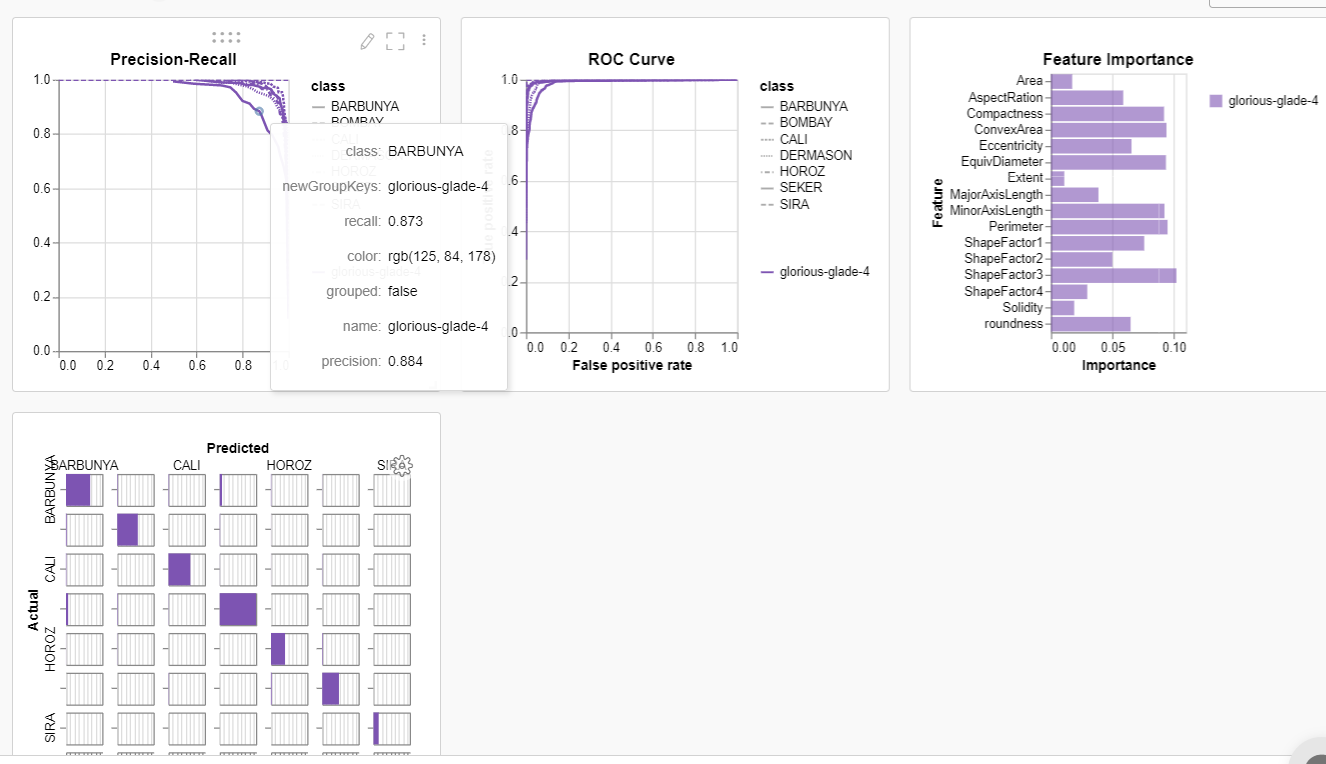

# Get Submission Files From a Sweeps Run

You can download the test set predictions from each Sweeps run via Artifacts. Or you can find which parameters resulted in the best trained model, and replicate that training using the training and prediction code in the first part of this notebook.

In [ ]:
# Find the run_id of the best performing Sweeps run, it can be found in the URL in the W&B UI
RUN_ID = '4ve8wzer'

In [ ]:
# Download the submission file from artifacts
wandb.init(project=PROJECT, job_type='download_submission')
artifact = wandb.use_artifact(f'{wandb.run.entity}/{PROJECT}/{RUN_ID}_submission:latest', type='submission')
artifact_dir = artifact.download('my_submissions')
wandb.finish()

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
